# Project Models - CART, Random Forest, Boosting

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn import datasets, linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [280]:
# Helper functions

def VIF(df, columns): 
    values=sm.add_constant(df[columns]).values
    # the dataframe passed to VIF␣ ↪ must include the intercept term. We add it the same way we did before. 
    num_columns=len(columns)+1#we added intercept 
    vif=[variance_inflation_factor(values, i) for i in range(num_columns)] 
    return pd.Series(vif[1:], index=columns)
def OSR2(model, y_train, x_test,y_test):
    y_pred=model.predict(x_test) 
    SSE=np.sum((y_test-y_pred)**2) 
    SST=np.sum((y_test-np.mean(y_train))**2) 
    return 1-(SSE/SST)
def avg_error(y_pred, y_test):
    return np.average(abs((y_pred - y_test) / y_test))

## Load Data - Train & Test split with time benchmark

In [281]:
training_data, testing_data = pd.read_csv('../features_train.csv'), pd.read_csv('../features_test.csv')
training_data.drop(columns=['since', 'until','Unnamed: 0'], inplace=True)
testing_data.drop(columns=['since', 'until','Unnamed: 0'], inplace=True)

training_data['Previous Sentiment'] = training_data['Sentiment'].shift(1)
training_data = training_data[1:]
testing_data['Previous Sentiment'] = testing_data['Sentiment'].shift(1)
testing_data = testing_data[1:]

## Linear Regression & Feature Engineering

In [282]:
X_train = training_data.drop(columns=['Tesla Stock Price'])
y_train = training_data['Tesla Stock Price']
X_test = testing_data.drop(columns=['Tesla Stock Price'])
y_test = testing_data['Tesla Stock Price']

#use only the important features
features = X_train.columns
X_test.head()

,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Week Tesla Stock Price,Previous Sentiment
1,991.539720,9.175,35.2625,141.020000,11.4350,4993.25,0.092409,33.525466,0.170538
2,1177.017305,8.912,33.6580,141.806000,10.9860,5090.60,0.134267,35.679167,0.092409
3,952.388795,8.566,34.2160,141.556000,10.8040,7696.80,0.231126,38.820533,0.134267
4,1357.345395,8.150,34.9600,141.413998,10.2300,4934.60,0.205790,51.983867,0.231126
5,2220.081724,7.995,34.8175,138.842499,9.0725,5107.75,0.105737,52.226400,0.205790


In [283]:
#Now we want to see how the model behaves. We train the linear regression.
#We will mostly focus on the p-values, the VIF values, and R2.
X=X_train
Y=y_train
X2 = sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, features))

pd.set_option('display.max_colwidth', None) 

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4236.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:42   Log-Likelihood:                -517.44
No. Observations:                 433   AIC:                             1055.
Df Residuals:                     423   BIC:                             1096.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [284]:
#We see that the p-values are very high for some features, we should eliminate them.
#We eliminate Tesla Wikipedia, since it has a very high p-value as well as a high VIF value.
X_train = X_train.drop(columns=['Tesla Wikipedia Page Views'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4777.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:42   Log-Likelihood:                -517.44
No. Observations:                 433   AIC:                             1053.
Df Residuals:                     424   BIC:                             1090.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [285]:
#Now we eliminate Nissan stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Nissan Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5472.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:42   Log-Likelihood:                -517.45
No. Observations:                 433   AIC:                             1051.
Df Residuals:                     425   BIC:                             1083.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [286]:
#Now we eliminate  SP500 Variance , since it has a very high p-value
X_train = X_train.drop(columns=['S&P 500 Variance'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     6397.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:43   Log-Likelihood:                -517.52
No. Observations:                 433   AIC:                             1049.
Df Residuals:                     426   BIC:                             1078.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [287]:
#Now we eliminate Sentiment scores, since it has a very high p-value
X_train = X_train.drop(columns=['Sentiment'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     7679.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:43   Log-Likelihood:                -517.98
No. Observations:                 433   AIC:                             1048.
Df Residuals:                     427   BIC:                             1072.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [288]:
#Now we eliminate GM stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['GM Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9576.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:43   Log-Likelihood:                -518.98
No. Observations:                 433   AIC:                             1048.
Df Residuals:                     428   BIC:                             1068.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [289]:
#Now we eliminate Ford stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Ford Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                            OLS Regression Results                            
Dep. Variable:      Tesla Stock Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.276e+04
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        23:41:44   Log-Likelihood:                -519.55
No. Observations:                 433   AIC:                             1047.
Df Residuals:                     429   BIC:                             1063.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

   const  Toyota Stock Price  Previous Week Tesla Stock Price  \
1    1.0          141.020000                        33.525466   
2    1.0          141.806000                        35.679167   
3    1.0          141.556000                        38.820533   
4    1.0          141.413998                        51.983867   
5    1.0          138.842499                        52.226400   

   Previous Sentiment  
1            0.170538  
2            0.092409  
3            0.134267  
4            0.231126  
5            0.205790  
R2 Score: 0.9725628720968355
OSR2 Score: 0.992262564877033
Mean Absolute Error: 10.103249325459068
Mean Absolute Error Percentage: 0.07147073729254058


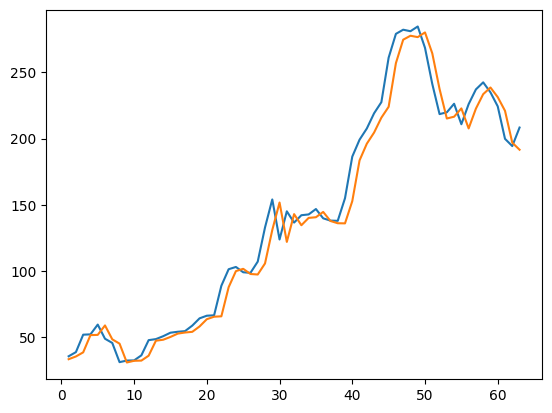

In [290]:
from sklearn.metrics import r2_score

X_test = testing_data.drop(columns=['Tesla Stock Price','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])
X_test=sm.add_constant(X_test)
print(X_test.head())
y_pred = lrm.predict(X_test)

# Assuming y_test and y_pred are the actual and predicted values, respectively
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

osr2=OSR2(lrm, y_train, X_test, y_test)
print("OSR2 Score:", osr2)

mean_absolute_error = np.mean(np.abs(y_test - y_pred))
mean_absolute_error_percentage = mean_absolute_error / np.mean(y_test)
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Absolute Error Percentage:", mean_absolute_error_percentage)

plt.plot(y_test)
plt.plot(y_pred)
plt.show()

## Load Data - Train & Test split with time benchmark

#### Random split is needed for tree-based models since the range of possible stock price values changes over time

In [291]:
data = pd.read_csv("../data.csv")
train_data, test_data = train_test_split(data)
test_data = test_data.drop(columns=['since', 'until','Unnamed: 0'])
train_data = train_data.drop(columns=['since', 'until','Unnamed: 0'])

train_data['Previous Sentiment'] = train_data['Sentiment'].shift(1)
train_data = train_data[1:]
test_data['Previous Sentiment'] = test_data['Sentiment'].shift(1)
test_data = test_data[1:]

In [292]:
y_train = train_data['Tesla Stock Price']
X_train = train_data.drop(columns=['Tesla Stock Price','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])

y_test = test_data['Tesla Stock Price']
X_test = test_data.drop(columns=['Tesla Stock Price','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])

## CART

In [293]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)
test_pred_cart, train_pred_cart = dtr_cv.predict(X_test), dtr_cv.predict(X_train)

## RANDOM FORESTS

In [296]:
grid_values = {'max_features': np.linspace(1,5,5, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

rf2 = RandomForestRegressor() 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)
test_pred_rf, train_pred_rf = rf_cv.predict(X_test), rf_cv.predict(X_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_es

## GRADIENT BOOSTED TREES

In [298]:
reg = GradientBoostingRegressor(random_state=99)
reg.fit(X_train, y_train)
test_pred_reg, train_pred_reg = reg.predict(X_test), reg.predict(X_train)

## Ensemble Model Blending

In [305]:
train = pd.DataFrame({'Tesla_Stock_Price': y_train, 'val_pred_cart': train_pred_cart, 'val_pred_rf': train_pred_rf, 'val_pred_reg': train_pred_reg})
test = pd.DataFrame({'Tesla_Stock_Price': y_test, 'val_pred_cart': test_pred_cart, 'val_pred_rf': test_pred_rf, 'val_pred_reg': test_pred_reg})
ensemble_model = smf.ols(formula='Tesla_Stock_Price ~ val_pred_cart+val_pred_reg+val_pred_rf -1', data=train).fit()

## Model Comparison

In [306]:
comparison_data = {'Linear Regressor': ['{:.3f}'.format(OSR2(lrm, y_train, sm.add_constant(X_test), y_test)),
                                               '{:.4f}'.format(avg_error(lrm.predict(sm.add_constant(X_test)), y_test))],
                    'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, y_train, X_test, y_test)),
                                               '{:.4f}'.format(avg_error(dtr_cv.predict(X_test), y_test))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, y_train, X_test, y_test)),
                                     '{:.4f}'.format(avg_error(rf_cv.predict(X_test), y_test))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(reg, y_train, X_test, y_test)),
                                              '{:.4f}'.format(avg_error(reg.predict(X_test), y_test))],
                  'Ensemble Model': ['{:.3f}'.format(OSR2(ensemble_model, y_train, test, y_test)),
                                              '{:.4f}'.format(avg_error(ensemble_model.predict(test), y_test))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Average Percent Test Error'])
comparison_table

,Linear Regressor,Decision Tree Regressor,Random Forest,Gradient Boosted Trees,Ensemble Model
OSR2,0.993,0.951,0.985,0.989,0.989
Average Percent Test Error,0.0550,0.0729,0.0588,0.0622,0.0629
